# SLU15: Working With Real Data
---

> Happy datasets are all alike; every unhappy dataset is unhappy in its own way.

(Shamelessly adapted from [Tolstoy's Anna Karenina](https://en.wikipedia.org/wiki/Anna_Karenina_principle).)

# 1 Tidy data principles

At the begining of any project, it is critical to structure datasets in a way that facilitiates work.

Most datasets are dataframes made up of rows and colums, containing a values that belong to a variable and an observation:
* *Variables* contain all values that measure the same thing across observations
* *Observations* contain all values measured on the same unit (e.g., same person) across variables.

The ideas of *tidy data* ([Wickham, 2014](http://vita.had.co.nz/papers/tidy-data.html)) provide a standardized framework to organise and structure datasets, making them easy to manipulate, model and visualize.
1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table (or dataframe).

We will be using a preprocessed version of the `avengers` dataset, by [FiveThirtyEight](http://fivethirtyeight.com/).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

avengers = pd.read_csv('data/avengers.csv')
avengers.head(3)

,Name,Active,Gender,Membership,Universe,IntroYear,Appearances,TotalDeaths,TotalReturns
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616,1963,1269,1,0
1,Janet van Dyne,YES,FEMALE,Full,Earth-616,1963,1165,1,1
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616,1963,3068,1,1


# 2 Types of data in Pandas

As stated above, a dataset is a collection of values, usually either numbers (quantitative) or strings (qualitative).

In [2]:
avengers.dtypes

Name            object
Active          object
Gender          object
Membership      object
Universe        object
IntroYear        int64
Appearances      int64
TotalDeaths      int64
TotalReturns     int64
dtype: object

Pandas main data types are:
* Numeric (`int`, `float`)
* Datetime (`datetime`, `timedelta`)
* Object (for strings).

The convenient `DataFrame.select_dtypes` allows us to select variables (columns in our dataframe) by type.

In [3]:
(avengers.select_dtypes(include='object')
         .head(3))

,Name,Active,Gender,Membership,Universe
0,"Henry Jonathan ""Hank"" Pym",YES,MALE,Full,Earth-616
1,Janet van Dyne,YES,FEMALE,Full,Earth-616
2,"Anthony Edward ""Tony"" Stark",YES,MALE,Full,Earth-616


We can use `pandas.to_datetime` to convert values to `datetime`.

We will use `df.assign` as an alternative to `avengers['IntroYear'] = ...` to return a new dataframe with all original columns, in addition to the new (or updated) ones.

In [4]:
(avengers.assign(IntroYear = pd.to_datetime(avengers['IntroYear'], format='%Y'))
         .tail(3))

,Name,Active,Gender,Membership,Universe,IntroYear,Appearances,TotalDeaths,TotalReturns
152,Victor Alvarez,YES,MALE,Full,Earth-616,2014-01-01,45,0,0
153,Ava Ayala,YES,FEMALE,Full,Earth-616,2014-01-01,49,0,0
154,Kaluu,YES,MALE,Full,Earth-616,2015-01-01,35,0,0


This makes much more sense, we should keep it.

In [5]:
avengers = avengers.assign(IntroYear = pd.to_datetime(avengers['IntroYear'], 
                                                      format='%Y'))

# 3 Apply functions over variables (or columns)

Pandas provides us with a convient `df.apply` method that enable us to apply over entire columns. 

Let's use it to compute the mean and the mode for numeric and non-numeric values, respectively.

In [6]:
import numpy as np

(avengers.select_dtypes(include='int')
         .apply(np.mean))

Appearances     446.219355
TotalDeaths       0.509677
TotalReturns      0.348387
dtype: float64

In [7]:
from scipy import stats

(avengers.select_dtypes(exclude='int')
         .apply(stats.mode))

Name                ([Vance Astrovik], [2])
Active                         ([NO], [79])
Gender                      ([MALE], [105])
Membership                  ([Full], [124])
Universe               ([Earth-616], [144])
IntroYear     ([2013-01-01 00:00:00], [18])
dtype: object

# 4 Apply functions over observations (or rows)

Alternatively, we can use `df.apply` to apply functions over rows with a little adjustment, by setting `axis=1`.

As an experiment, let's try to scale each row to a unit vector, by dividing each value by the norm of the row vector

In [8]:
from numpy.linalg import norm

def normalize(row):
    """
    Takes a vector of values and transforms it into a unit vector with length 1.
    This is achieved by computing v / ||v|| for each value in the row vector.
    """
    return row / norm(row)

(avengers.select_dtypes(include='int')
         .apply(normalize, axis=1)
         .apply(norm, axis=1)
         .sample())

85    1.0
dtype: float64

# 5 Types of statistical data

There are three main types of statistical data:
1. Numerical (discrete and continuous)
2. Categorical (binary, low cardinality and high cardinality)
3. Ordinal

## 5.1 Numerical data

Numerical data is information that is measurable. It's always collected in number form, although not all data in number form is numerical.

Things we can do with numerical data:
* Mathematical operations (e.g., from addition, to distances and the normalization above)
* Sort it in ascending or descending order.

**Discrete data**

Discrete data take on certain values, although the list of values may be finite  or not. 

Some data can even be continuous, but measured in a discrete way (e.g., age). 

Likewise, `IntroYear`, `TotalDeaths` and `TotalReturns` in our `avengers` data are discrete variable.

**Continuous data**

Continuous data can take any value within a range: `Appearances` is an example in our data.

### 5.1.1 Scaling numerical values

Often times, the numeric variables in our dataset have very different scales, that is, take on different ranges of values.

It's usually a good practice to scale them during the preprocessing of our data, typically you will do one of two things:
1. Scale variables to a given range
2. Standardize all variables.

These transformations change the data but not the distribution. Why is it important to scale the data:
* When predictor values have different ranges, particular features can dominate the algorithm (e.g., think [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance))
* Different scales can make estimators unable to learn correctly from certain features in smaller ranges
* You don't want your feature to rely on the scale of the measurement involved
* Optimization methods such as gradient descent will converge faster.

**Scale all variables to a given range**

We would transform all variables so that the minimum and the maximum of the transformed data take certain values, e.g., 0 and 1:

$$ x'_i = \frac{x_i - x_{min}}{x_{max} - x_{min}} $$

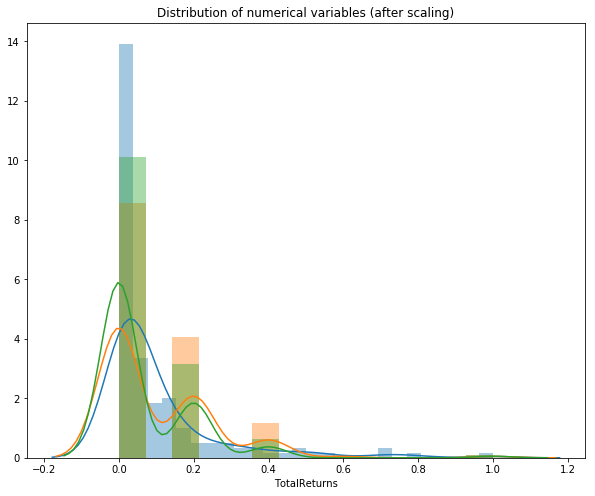

,Appearances,TotalDeaths,TotalReturns
count,155.000000,155.000000,155.000000
mean,0.102567,0.101935,0.069677
std,0.162742,0.153518,0.134055
min,0.000000,0.000000,0.000000
25%,0.014662,0.000000,0.000000
50%,0.036019,0.000000,0.000000
75%,0.121681,0.200000,0.200000
max,1.000000,1.000000,1.000000


In [9]:
from sklearn.preprocessing import MinMaxScaler

def scale_data(df, scaler):
    df = df.copy()
    cols = df.select_dtypes(include='int').columns
    df[cols] = scaler.fit_transform(df[cols])
    plot_scaled_data(df, cols)
    return df

def plot_scaled_data(df, cols):
    plt.figure(figsize=(10, 8))
    for col in cols:
        sns.distplot(df[col])
    plt.title('Distribution of numerical variables (after scaling)')
    plt.show()
    return None

min_max_scaler = MinMaxScaler()
(avengers.pipe(scale_data, min_max_scaler)
         .describe())

**Standardize all variables**

Standardization means both centering the data around 0 (by removing the mean) and scaling it to unit variance:

$$ z_i =  \frac{x_i - \mu}{\sigma}$$

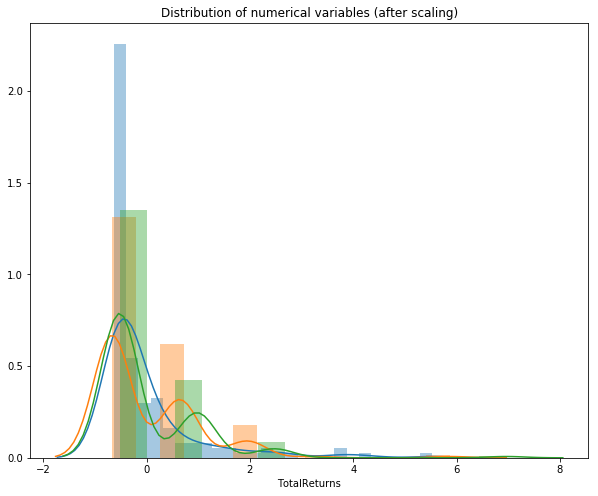

,Appearances,TotalDeaths,TotalReturns
count,1.550000e+02,1.550000e+02,155.000000
mean,-6.876220e-17,6.876220e-17,0.000000
std,1.003241e+00,1.003241e+00,1.003241
min,-6.322885e-01,-6.661510e-01,-0.521453
25%,-5.419045e-01,-6.661510e-01,-0.521453
50%,-4.102428e-01,-6.661510e-01,-0.521453
75%,1.178275e-01,6.408541e-01,0.975311
max,5.532327e+00,5.868874e+00,6.962366


In [10]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
(avengers.pipe(scale_data, standard_scaler)
         .describe())

## 5.2 Categorical data

Categorical data represents categories (e.g., gender, marital status, hometown).

Categorical variables can take on a limited, and usually fixed, number of possible values, also known as levels.

The categories can also take on numerical values (e.g., ratings), but those numbers have no mathematical meaning:
* You can't do mathematical operations, even if the computer says yes
* Nor sort them in ascending or descending order.

**Binary data**

`Active` and `Gender`

Algorithms can't read numerical data

The method `Series.map` allows us to easily deal with this cases, mapping inputs to outputs.

In [11]:
(avengers['Active'].map({'YES': 1, 'NO': 0})
                   .head(n=3))

0    1
1    1
2    1
Name: Active, dtype: int64

Let's convert both columns to numerical values.

In [12]:
#avengers = avengers.assign(Active=avengers['Active'].map({'YES': 1, 'NO': 0}),
#                           Gender=avengers['Gender'].map({'MALE': 1, 
                                                          'FEMALE': 0}))
#avengers.head(3)

IndentationError: unexpected indent (<ipython-input-12-fb711311df2b>, line 3)

**Low cardinality data**

`Universe`

Categorical dtype

get dummies

**High cardinality data**

## 5.3 Ordinal data

`Membership`

Label encoder (Series.map becomes unpractical)

# 6 Bonus

## 6.1 Scaling with outliers

## 6.2 Other ways to dummify